<a href="https://colab.research.google.com/github/AntonioBorz/CourseWork_ClassicML/blob/main/4_%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%B4%D0%BB%D1%8F_SI_Borzunov_A_A_CML_%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **4 Регрессия для SI**

In [1]:
# Импортируем необходимые библиотеки
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
!pip install catboost
from catboost import CatBoostRegressor
import joblib
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00


1. Загрузка данных после EDA

In [2]:
# Загружаем данные
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/EDAprocessed_data.xlsx')

Mounted at /content/drive


In [3]:
# Проверим датасет
print(f"Количество строк: {len(df)}")
print(f"Количество столбцов: {len(df.columns)}")

# Посмотрим первые строчки
df.head()

Количество строк: 969
Количество столбцов: 178


,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan3,BCUT2D_MWHI,...,log_SI,"IC50, mM","CC50, mM",SI,Charge_Difference,Charge_Stability,EState_Range,Total_Functional_Groups,Functional_Diversity,Complexity_Score
0,5.094096,0.387225,0.387225,0.417362,42.928571,0,0.038844,-0.293526,1.321429,14.822266,...,3.371597,6.239374,175.482382,28.125000,0.332369,0.717222,4.706871,11,4,4.998389
1,3.961417,0.533868,0.533868,0.462473,45.214286,0,0.012887,-0.313407,1.285714,14.975110,...,2.079442,0.771831,5.402819,7.000000,0.326294,0.721593,3.427548,9,3,4.928514
2,2.627117,0.543231,0.543231,0.260923,42.187500,0,0.094802,-0.325573,1.156250,15.353938,...,0.542324,223.808778,161.142320,0.720000,0.420375,0.656801,2.083887,11,4,4.353918
3,5.097360,0.390603,0.390603,0.377846,41.862069,0,0.038844,-0.293526,1.310345,14.821216,...,4.162553,1.705624,107.855654,63.235294,0.332369,0.717223,4.706757,12,4,4.924259
4,5.150510,0.270476,0.270476,0.429038,36.514286,0,0.062897,-0.257239,1.257143,14.831112,...,0.832909,107.131532,139.270991,1.300000,0.320137,0.726050,4.880034,8,3,4.556793


2. Подготовка данных

In [4]:
# Подготавливаем целевую переменную и признаки
target_si = 'log_SI'
y_si = df[target_si]

In [6]:
# Исключаем целевые переменные из признаков (кроме 'log_IC50, mM' и 'log_CC50, mM')
exclude_cols = ['IC50, mM', 'CC50, mM', 'SI', 'log_SI']
X_cols_si = [col for col in df.columns if col not in exclude_cols]
X_si = df[X_cols_si]

In [7]:
# Разделяем данные
X_train_si, X_test_si, y_train_si, y_test_si = train_test_split(
    X_si, y_si, test_size=0.2, random_state=42, stratify=pd.qcut(y_si, q=5, duplicates='drop')
)

feature_names = X_train_si.columns.tolist()

print(f"Размер обучающей выборки: {X_train_si.shape}")
print(f"Размер тестовой выборки: {X_test_si.shape}")

Размер обучающей выборки: (775, 174)
Размер тестовой выборки: (194, 174)


In [8]:
# Масштабируем данные (только для моделей, чувствительных к масштабу)
scaler_si = RobustScaler()
X_train_si_scaled = scaler_si.fit_transform(X_train_si)
X_test_si_scaled = scaler_si.transform(X_test_si)

3. Определение и подготовка набора моделей

In [9]:
# Создаем модели для SI
models_si = {
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=1000, random_state=42, n_jobs=-1, verbosity=0),
    'CatBoost': CatBoostRegressor(iterations=500, random_state=42, verbose=False, thread_count=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=300, random_state=42),
    'Ridge': Ridge(),
    'SVR': SVR()
}

# Ансамблевые методы с оптимизацией скорости
fast_models = {
    'xgb_fast': xgb.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        tree_method='hist'
    ),
    'cat_fast': CatBoostRegressor(
        iterations=200,
        depth=6,
        random_state=42,
        verbose=False,
        thread_count=-1,
        boosting_type='Plain'
    )
}

# Стекинг с оптимизацией
stacking_model = StackingRegressor(
    estimators=[
        ('xgb_fast', fast_models['xgb_fast']),
        ('cat_fast', fast_models['cat_fast'])
    ],
    final_estimator=Ridge(),
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1
)

# Голосование с оптимизацией
voting_model = VotingRegressor(
    estimators=[
        ('xgb_fast', fast_models['xgb_fast']),
        ('cat_fast', fast_models['cat_fast'])
    ],
    n_jobs=-1
)

# Добавляем ансамбли в общий список
models_si.update({
    'Stacking': stacking_model,
    'Voting': voting_model
})

4. Оценка моделей и выбор лучшей модели

In [10]:
# Создаем функцию для оценки моделей - пробовал разные варианты, остановился на этом с кросс-валидацией
def evaluate_models(models, X_train, X_test, y_train, y_test, cv_folds=10):
    """Оцениваем модели с помощью кросс-валидации и тестовой выборки"""
    results = {}
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"\nОцениваем модель: {name}")

        try:
            # Кросс-валидация с несколькими метриками
            cv_mae = -cross_val_score(model, X_train, y_train, cv=cv,
                                     scoring='neg_mean_absolute_error', n_jobs=-1)
            cv_r2 = cross_val_score(model, X_train, y_train, cv=cv,
                                   scoring='r2', n_jobs=-1)

            # Обучение модели
            model.fit(X_train, y_train)

            # Предсказания
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

            # Вычисление метрик
            results[name] = {
                'CV_MAE_mean': cv_mae.mean(),
                'CV_MAE_std': cv_mae.std(),
                'CV_R2_mean': cv_r2.mean(),
                'CV_R2_std': cv_r2.std(),
                'Train_MAE': mean_absolute_error(y_train, y_pred_train),
                'Test_MAE': mean_absolute_error(y_test, y_pred_test),
                'Train_R2': r2_score(y_train, y_pred_train),
                'Test_R2': r2_score(y_test, y_pred_test),
                'Model': model
            }

            # Проверка на переобучение
            r2_diff = results[name]['Train_R2'] - results[name]['Test_R2']
            mae_diff = results[name]['Test_MAE'] - results[name]['Train_MAE']

            if r2_diff > 0.15 or mae_diff > 0.1:
                print(f"Возможно переобучение: ΔR²={r2_diff:.3f}, ΔMAE={mae_diff:.3f}")

        except Exception as e:
            print(f"Ошибка при оценке модели: {str(e)}")

    return results

In [11]:
# Оценка на исходных данных (для деревянных)
tree_models = {k: v for k, v in models_si.items() if k not in ['Ridge', 'ElasticNet', 'SVR', 'KNN', 'MLP']}
results_original = evaluate_models(tree_models, X_train_si, X_test_si, y_train_si, y_test_si)

# Оценка на масштабированных данных (для линейных моделей)
scaled_models = {k: v for k, v in models_si.items() if k in ['Ridge', 'ElasticNet', 'SVR', 'KNN', 'MLP']}
results_scaled = evaluate_models(scaled_models, X_train_si_scaled, X_test_si_scaled,
                                y_train_si, y_test_si)

# Объединение результатов
all_results_si = {**results_original, **{f"{k}_scaled": v for k, v in results_scaled.items()}}

# Сводная таблица результатов
results_df_si = pd.DataFrame(all_results_si).T
results_df_si = results_df_si.sort_values('Test_R2', ascending=False)

print("\nРЕЗУЛЬТАТЫ МОДЕЛЕЙ ДЛЯ SI:")
display_cols = ['CV_R2_mean', 'Test_R2', 'Test_MAE', 'CV_MAE_mean']
print(results_df_si[display_cols].round(4))


Оцениваем модель: RandomForest

Оцениваем модель: XGBoost
Возможно переобучение: ΔR²=0.015, ΔMAE=0.114

Оцениваем модель: CatBoost

Оцениваем модель: GradientBoosting

Оцениваем модель: Stacking

Оцениваем модель: Voting

Оцениваем модель: Ridge

Оцениваем модель: SVR

РЕЗУЛЬТАТЫ МОДЕЛЕЙ ДЛЯ SI:
                 CV_R2_mean   Test_R2  Test_MAE CV_MAE_mean
CatBoost           0.972041  0.992533  0.083752     0.12299
Stacking            0.97516  0.991913  0.093118    0.136107
Voting             0.975717  0.991137  0.093102    0.116548
GradientBoosting   0.978675  0.990742  0.093158    0.117907
RandomForest       0.947635  0.985714  0.104429    0.149448
XGBoost            0.963123  0.984695  0.115003    0.143246
Ridge_scaled       0.898637  0.919382  0.247359    0.268483
SVR_scaled         -0.10145 -0.103177  1.108587    1.079307


In [12]:
# Выбираем лучшую модель
best_model_name_si = results_df_si.index[0]
best_model_si = results_df_si.loc[best_model_name_si, 'Model']
best_model_type = type(best_model_si).__name__

print(f"Лучшая модель: {best_model_name_si} ({best_model_type})")
print(f"Test R²: {results_df_si.loc[best_model_name_si, 'Test_R2']:.4f}")
print(f"Test MAE: {results_df_si.loc[best_model_name_si, 'Test_MAE']:.4f}")

Лучшая модель: CatBoost (CatBoostRegressor)
Test R²: 0.9925
Test MAE: 0.0838


In [13]:
# Донастраиваем модель
if 'scaled' in best_model_name_si:
    X_train_final, X_test_final = X_train_si_scaled, X_test_si_scaled
else:
    X_train_final, X_test_final = X_train_si, X_test_si

# Определяем параметры в зависимости от типа модели
best_model_type = type(best_model_si).__name__

if best_model_type == 'CatBoostRegressor':
    param_grid = {
        'iterations': [300, 500, 700],
        'depth': [4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5]
    }
elif best_model_type == 'GradientBoostingRegressor':
    param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_type == 'RandomForestRegressor':
    param_grid = {
        'n_estimators': [400, 500, 600],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
elif best_model_type == 'XGBRegressor':
    param_grid = {
        'n_estimators': [800, 1000, 1200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
else:  # Для остальных моделей используем упрощенную настройку
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 2.0],
        'fit_intercept': [True, False]
    } if best_model_type in ['Ridge', 'ElasticNet'] else {}

    # Для моделей, которые не поддерживают настройку
    if not param_grid:
        tuned_model_si = best_model_si
        y_pred_tuned = best_model_si.predict(X_test_final)
        tuned_r2 = r2_score(y_test_si, y_pred_tuned)
        tuned_mae = mean_absolute_error(y_test_si, y_pred_tuned)

        print(f"\nРезультаты базовой модели:")
        print(f"Test R²: {tuned_r2:.4f}")
        print(f"Test MAE: {tuned_mae:.4f}")

        # Сравнение не требуется, так как модель не настраивалась
        improvement = 0.0
        final_model_si = tuned_model_si

# Если для модели определены параметры настройки
if 'param_grid' in locals() and param_grid:
    random_search = RandomizedSearchCV(
        estimator=best_model_si,
        param_distributions=param_grid,
        n_iter=15,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    random_search.fit(X_train_final, y_train_si)
    tuned_model_si = random_search.best_estimator_

    # Оценка настроенной модели
    y_pred_tuned = tuned_model_si.predict(X_test_final)
    tuned_r2 = r2_score(y_test_si, y_pred_tuned)
    tuned_mae = mean_absolute_error(y_test_si, y_pred_tuned)

    print(f"\nРезультаты после настройки:")
    print(f"Лучшие параметры: {random_search.best_params_}")
    print(f"Test R²: {tuned_r2:.4f}")
    print(f"Test MAE: {tuned_mae:.4f}")

    # Сравнение с исходной моделью
    original_r2 = results_df_si.loc[best_model_name_si, 'Test_R2']
    improvement = tuned_r2 - original_r2
    print(f"Улучшение R²: {improvement:+.4f}")

    final_model_si = tuned_model_si

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Результаты после настройки:
Лучшие параметры: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 4}
Test R²: 0.9946
Test MAE: 0.0716
Улучшение R²: +0.0020


5. Анализ результатов и оценка важности признаков

In [14]:
# Создаем функцию для получения важности признаков
def get_feature_importance(model, feature_names, X_test, y_test):
    """Анализ важности признаков для различных типов моделей"""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
        if len(importance.shape) > 1:
            importance = np.mean(importance, axis=0)
    else:
        perm_importance = permutation_importance(
            model, X_test, y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        importance = perm_importance.importances_mean

    # Нормализуем важность для наглядности
    importance = 100.0 * (importance / importance.max())

    return pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

# Анализ важности признаков
feature_importance_si = get_feature_importance(
    final_model_si,
    feature_names,
    X_test_final,
    y_test_si
)

# Выводим топ-10 признаков
print("ТОП-10 ВАЖНЫХ ПРИЗНАКОВ ДЛЯ SI:")
top_features = feature_importance_si.head(10)
print(top_features.to_string(index=False))

ТОП-10 ВАЖНЫХ ПРИЗНАКОВ ДЛЯ SI:
          feature  importance
     log_IC50, mM  100.000000
     log_CC50, mM   54.917115
     FractionCSP3    1.152289
          BertzCT    1.121207
        RingCount    0.899117
      VSA_EState8    0.856256
MinAbsEStateIndex    0.402806
           AvgIpc    0.401203
              Ipc    0.354194
   MaxEStateIndex    0.316673


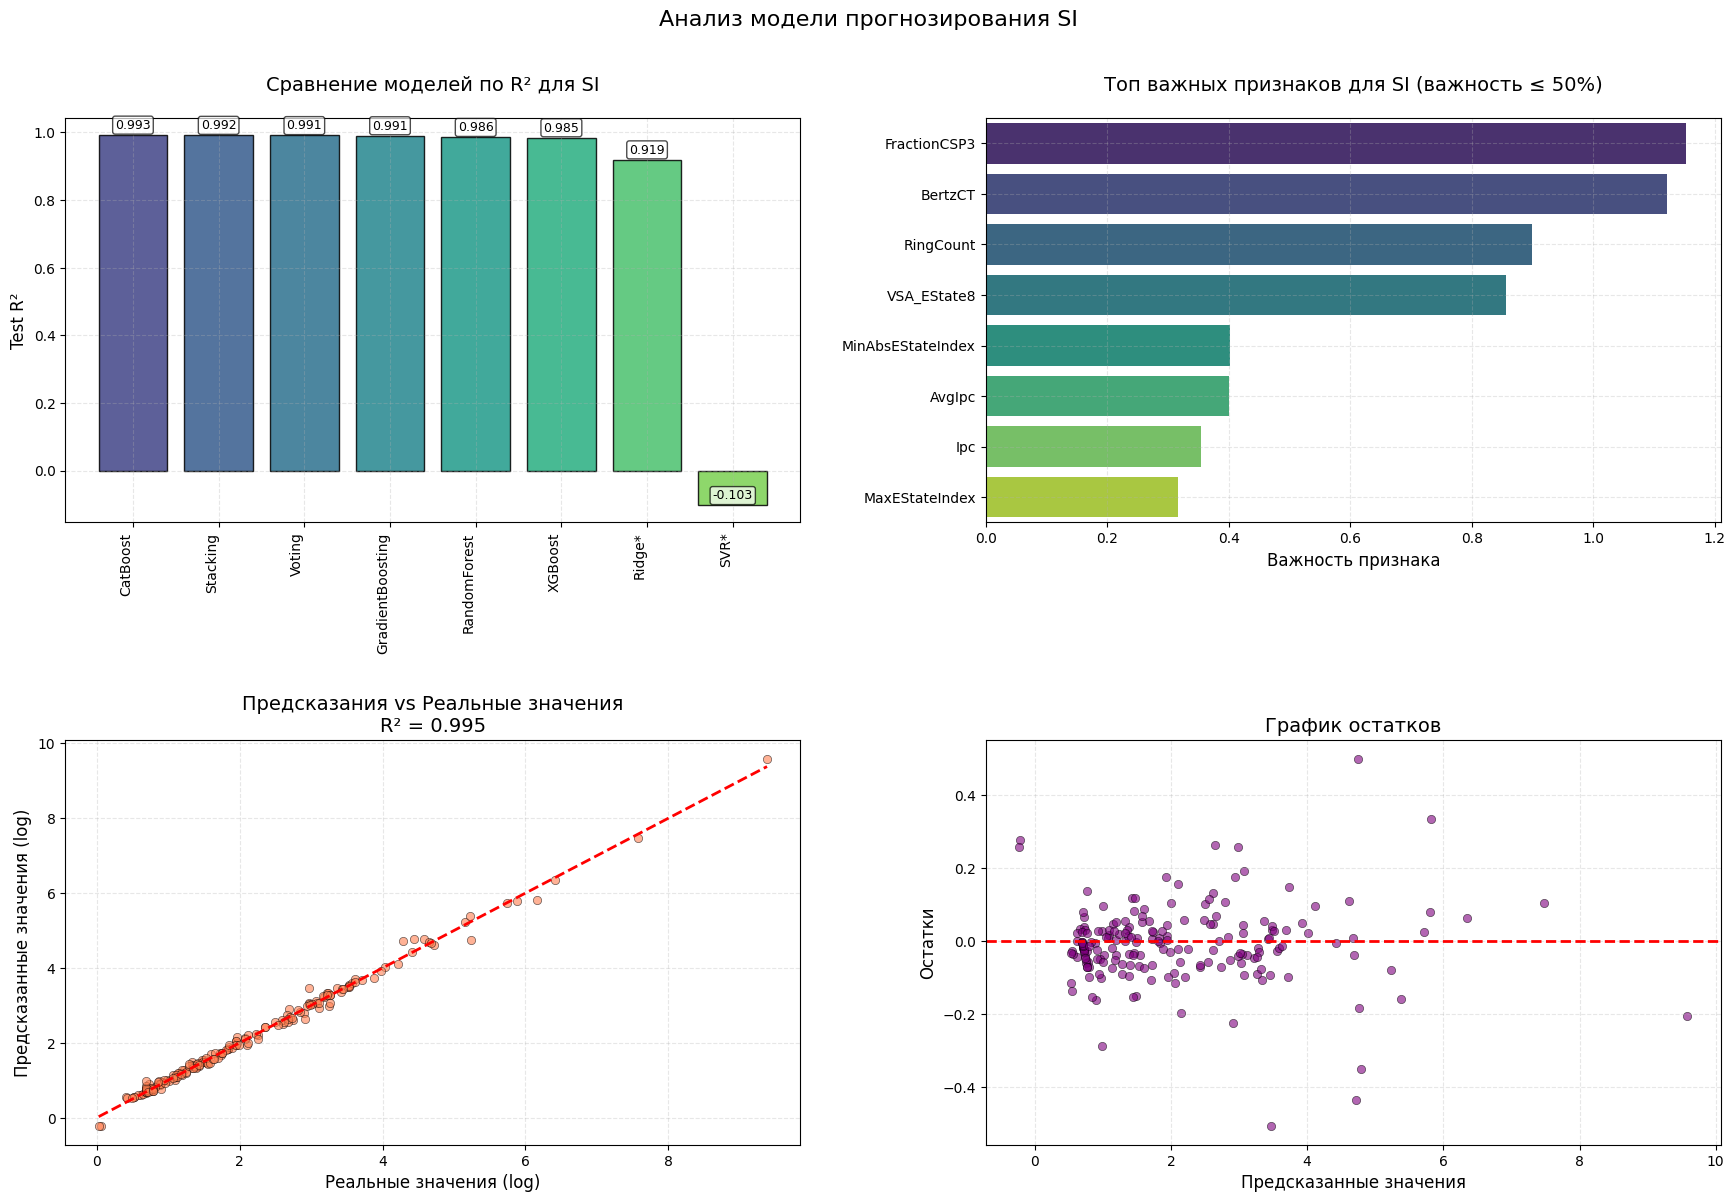

In [24]:
# Визуализация результатов
plt.figure(figsize=(18, 12))

# Сравнение моделей по R²
plt.subplot(2, 2, 1)
top_models = results_df_si.head(8)
model_names = [name.replace('_scaled', '*') for name in top_models.index]
r2_scores = top_models['Test_R2'].values
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(model_names)))
bars = plt.bar(range(len(model_names)), r2_scores, color=colors, edgecolor='black', alpha=0.85)
plt.xticks(range(len(model_names)), model_names, ha='right', rotation=90, fontsize=10)
plt.ylabel('Test R²', fontsize=12)
plt.title('Сравнение моделей по R² для SI', fontsize=14, pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(min(r2_scores) - 0.05, max(r2_scores) + 0.05)

# Добавляем значения на столбцы
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}',
             ha='center', va='bottom',
             fontsize=9,
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

# Важность признаков
plt.subplot(2, 2, 2)
# Фильтруем признаки с важностью <= 50%
top_features_filtered = top_features[top_features['importance'] <= 50]

if not top_features_filtered.empty:
    sns.barplot(
        x='importance',
        y='feature',
        data=top_features_filtered,
        hue='feature',
        palette='viridis',
        dodge=False,
        legend=False
    )
    plt.xlabel('Важность признака', fontsize=12)
    plt.ylabel('')
    plt.title('Топ важных признаков для SI (важность ≤ 50%)', fontsize=14, pad=20)
    plt.grid(True, alpha=0.3, linestyle='--')

# Предсказания vs Реальные значения
plt.subplot(2, 2, 3)
plt.scatter(y_test_si, y_pred_tuned, alpha=0.6, color='coral', edgecolor='k', linewidth=0.5)
plt.plot([min(y_test_si), max(y_test_si)], [min(y_test_si), max(y_test_si)],
         'r--', lw=2)
plt.xlabel('Реальные значения (log)', fontsize=12)
plt.ylabel('Предсказанные значения (log)', fontsize=12)
plt.title(f'Предсказания vs Реальные значения\nR² = {tuned_r2:.3f}', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

# Остатки
plt.subplot(2, 2, 4)
residuals = y_test_si - y_pred_tuned
plt.scatter(y_pred_tuned, residuals, alpha=0.6, color='purple', edgecolor='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Предсказанные значения', fontsize=12)
plt.ylabel('Остатки', fontsize=12)
plt.title('График остатков', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

# Общие настройки
plt.tight_layout(pad=3.0)
plt.suptitle('Анализ модели прогнозирования SI', fontsize=16, y=1.02)
plt.show()

In [25]:
# Сохраняем модель
joblib.dump(final_model_si, 'best_model_si.pkl')

# Сохраняем результаты
results_df_si.to_csv('si_model_results.csv')
top_features.to_csv('si_top_features.csv', index=False)
print("Результаты сохранены!")

Результаты сохранены!
